In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import os
os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray
from datetime import datetime as dt
import pandas_market_calendars as mcal
import dateutil

In [2]:
# get range of dates from the last 100 days
import datetime
numdays = 100
# get current date
base = datetime.datetime.today()
# list comp for current date - number of days for range of dates
date_list = [base - datetime.timedelta(days=x) for x in range(numdays)]
# put into dataframe to do datetime formatting
dates = pd.DataFrame(date_list, columns = ['dates'])
dates['dates'] = pd.to_datetime(dates.dates)
dates['dates'] = dates['dates'].dt.strftime('%Y-%m-%d')
# sort dates ascending values
dates = dates.sort_values(by="dates", ascending=True)
# all dates are in a list to use in REST API to fetch data
dates = list(dates['dates'])

In [3]:
ticker = 'X:BTCUSD'
range_agg = '/range/1/day/'
unadjusted = 'unadjusted=true'
sort = '&sort=asc'
limit = '&limit=50000'
POLYGON_URL = 'https://api.polygon.io/v2/aggs/ticker/'
from_date = '2019-09-05'
to_date = '2021-09-05'
POLYGON_API = '&apiKey=x6XqEaDjOWJXwVQRyBQ5kMEi8KlCYZqo'

In [4]:
datetime = []
open_price = []
high_price = []
low_price = []
close_price = []
volume = []
#for date in dates:
polygon = POLYGON_URL + ticker + range_agg + from_date + '/' + to_date + '?' + unadjusted + sort + limit + POLYGON_API
r_polygon = requests.get(polygon)
polygon_response = r_polygon.json()
for aggs in range(len(polygon_response['results'])):
    datetime.append(dt.fromtimestamp(polygon_response['results'][aggs]['t']/ 1000.0).strftime('%Y-%m-%d %H:%M:%S'))
    open_price.append(polygon_response['results'][aggs]['o'])
    high_price.append(polygon_response['results'][aggs]['h'])
    low_price.append(polygon_response['results'][aggs]['l'])
    close_price.append(polygon_response['results'][aggs]['c'])
    volume.append(polygon_response['results'][aggs]['v'])

In [5]:
df = pd.DataFrame(list(zip(datetime,open_price,high_price,low_price, close_price,volume)),
columns =['datetime', 'open', 'high', 'low', 'close', 'volume'])

In [6]:
df.head()

,datetime,open,high,low,close,volume
0,2019-09-05 00:00:00,10564.15,10666.43,10446.49000,10574.73,35032.252292
1,2019-09-06 00:00:00,10574.28,10949.00,10145.29999,10308.92,64624.211791
2,2019-09-07 00:00:00,10309.04,10582.00,10296.94000,10457.42,35408.567930
3,2019-09-08 00:00:00,10484.37,10599.10,10223.80000,10405.00,24312.280987
4,2019-09-09 00:00:00,10401.13,10557.00,10051.00000,10310.01,45131.728632


In [7]:
len(df)

732

In [8]:
df['datetime']

0      2019-09-05 00:00:00
1      2019-09-06 00:00:00
2      2019-09-07 00:00:00
3      2019-09-08 00:00:00
4      2019-09-09 00:00:00
              ...         
727    2021-09-01 00:00:00
728    2021-09-02 00:00:00
729    2021-09-03 00:00:00
730    2021-09-04 00:00:00
731    2021-09-05 00:00:00
Name: datetime, Length: 732, dtype: object

In [9]:
df.describe()

,open,high,low,close,volume
count,732.000000,732.000000,732.000000,732.000000,732.000000
mean,21927.903146,22630.100736,21133.370270,21982.523825,64895.804139
std,17316.468515,17906.461429,16619.186559,17343.277867,46004.383359
min,4841.650000,5388.900000,3803.540000,4857.100000,9189.909507
25%,8915.017500,9199.427500,8713.630000,8918.000000,39047.796445
50%,11076.410000,11420.500000,10827.150000,11104.060000,53674.525737
75%,35672.200000,37544.470000,33910.675000,35710.472500,76878.574366
max,63519.000000,64900.000000,61980.000000,63587.200000,528649.592713


In [10]:
# Select only the important features i.e. the date and price
data = df[["datetime","close"]] # select Date and Price
# Rename the features: These names are NEEDED for the model fitting
data = data.rename(columns = {"datetime":"ds","close":"y"}) #renaming the columns of the dataset
data.tail(5)

,ds,y
727,2021-09-01 00:00:00,48823.00
728,2021-09-02 00:00:00,49279.37
729,2021-09-03 00:00:00,50018.60
730,2021-09-04 00:00:00,49946.41
731,2021-09-05 00:00:00,50429.90


In [11]:
from prophet import Prophet
m = Prophet(daily_seasonality = True) # the Prophet class (model)
m.fit(data) # fit the model using all data

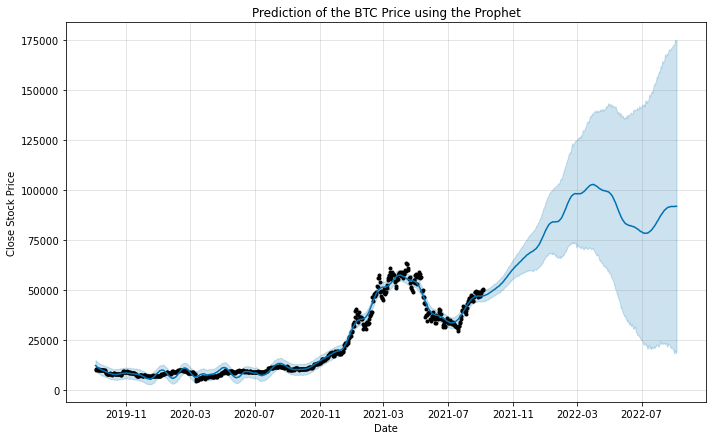

In [12]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the BTC Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

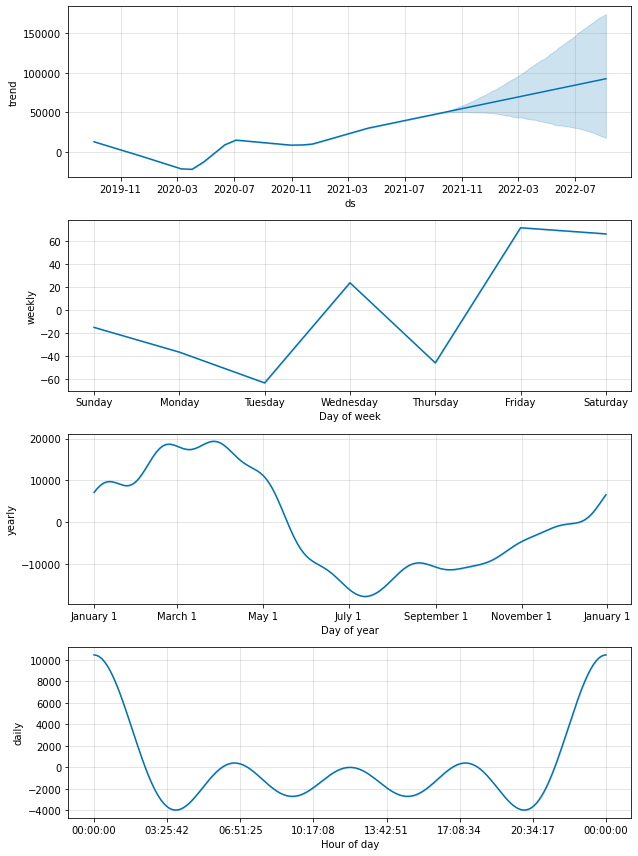

In [13]:
m.plot_components(prediction)
plt.show()

In [14]:
# try with some hyperparameter tuning
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation, performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, horizon='30 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 23 forecasts with cutoffs between 2020-09-10 00:00:00 and 2021-08-06 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9eb78530d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 23 forecasts with cutoffs between 2020-09-10 00:00:00 and 2021-08-06 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9eb78531d0>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:Making 23 forecasts with cutoffs between 2020-09-10 00:00:00 and 2021-08-06 00:00:00
INFO:prophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f9eb781f510>
INFO:prophet:Disabling daily seasonality. Run prophet with daily_se

    changepoint_prior_scale  seasonality_prior_scale          rmse
0                     0.001                     0.01  16904.488783
1                     0.001                     0.10  17924.300197
2                     0.001                     1.00  17912.856462
3                     0.001                    10.00  17871.848407
4                     0.010                     0.01  12855.204129
5                     0.010                     0.10  11284.937394
6                     0.010                     1.00  11512.612841
7                     0.010                    10.00  11399.379394
8                     0.100                     0.01  10019.528223
9                     0.100                     0.10   8469.629214
10                    0.100                     1.00   8556.973804
11                    0.100                    10.00   8570.269215
12                    0.500                     0.01   9163.667437
13                    0.500                     0.10   8659.92

In [15]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1}


In [16]:
m = Prophet(daily_seasonality = True, changepoint_prior_scale=0.1, seasonality_prior_scale=0.1) # the Prophet class (model)
m.fit(data)

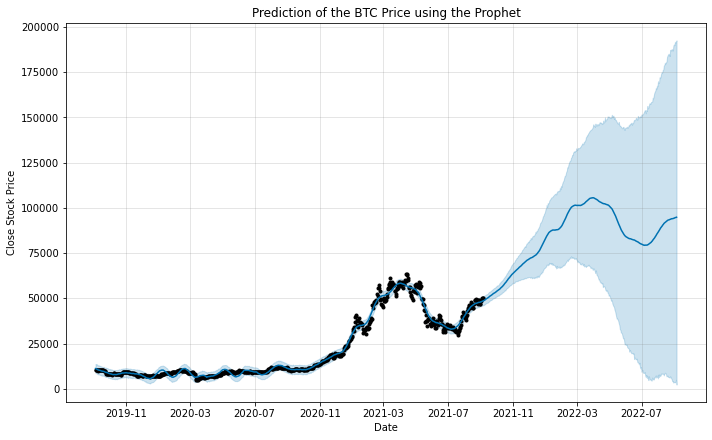

In [17]:
future = m.make_future_dataframe(periods=365) #we need to specify the number of days in future
prediction = m.predict(future)
m.plot(prediction)
plt.title("Prediction of the BTC Price using the Prophet")
plt.xlabel("Date")
plt.ylabel("Close Stock Price")
plt.show()

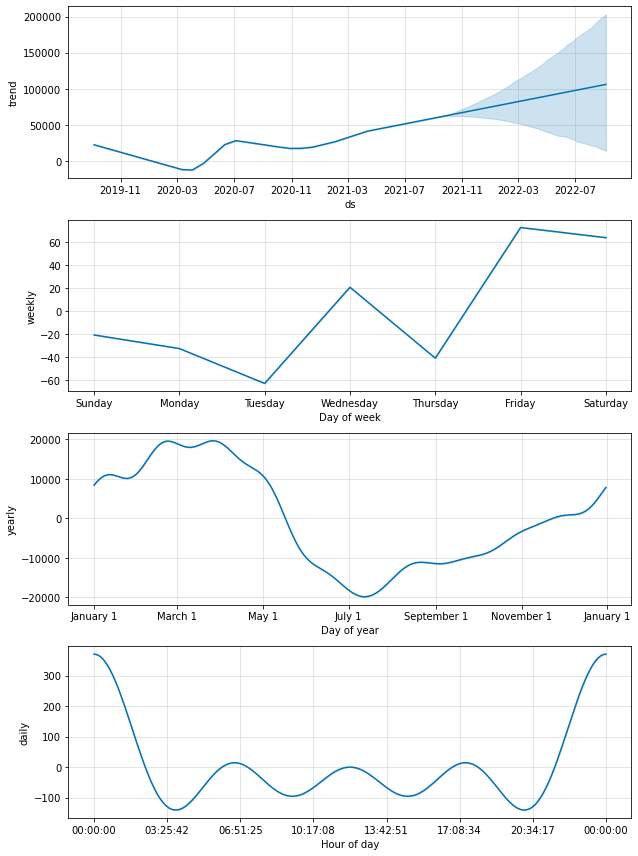

In [18]:
m.plot_components(prediction)
plt.show()